# **Deep Learning Exam Project**
---

### **Author**: Marta Paniconi

### **Goal**: Predict both *Review Type* (binary classification) and *Review Score* (regression)

---

# **STEP 0 – IMPORT LIBRARIES AND LOAD DATASET**
In this section, we import all the necessary Python libraries for deep learning, data preprocessing, evaluation, and visualization.


In [ ]:
# CORE PYTHON PACKAGES
import re, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# UTILITIES
from itertools import product

# TENSORFLOW / KERAS
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, LSTM,
                                     GlobalMaxPooling1D, Dense, Dropout,
                                     Concatenate, Flatten)
from tensorflow.keras.optimizers     import Adam
from tensorflow.keras.callbacks      import EarlyStopping
from tensorflow.keras.preprocessing.text      import Tokenizer
from tensorflow.keras.preprocessing.sequence  import pad_sequences
from tensorflow.keras.losses         import BinaryCrossentropy, MeanSquaredError

# SCIKIT-LEARN
from sklearn.model_selection import (train_test_split, ParameterSampler,
                                     StratifiedKFold)
from sklearn.preprocessing   import LabelEncoder, MinMaxScaler
from sklearn.metrics         import (accuracy_score, precision_score,
                                     recall_score, f1_score, confusion_matrix,
                                     mean_squared_error,
                                     ConfusionMatrixDisplay)

> We load the provided dataset and prepare it for analysis. As requested, we ensure the notebook is **self-contained** and does not require Drive access.


In [ ]:
url = "https://raw.githubusercontent.com/martapanic/deep_learning_exam/main/input_data.csv"
df = pd.read_csv(url)

# Preview the dataset
df.head()

,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
1,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
2,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
3,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
4,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review


# **STEP 1 - MODEL**
As described in the written exam, this model addresses a **multi-task learning problem**: classifying the review type and predicting the review score.

To achieve this, we adopt a **hybrid deep learning architecture**:
- A **Bidirectional LSTM** processes the sequential `Review` text, capturing both forward and backward contextual dependencies.
- A **Multi-Layer Perceptron (MLP)** handles structured metadata like `Reviewer_Nationality` and `Reviewer_number_reviews`.

This design allows the model to **share representations across tasks**, improving generalization and robustness.

Below we define a few **core architectural parameters** based on the exam response. These are **fixed design choices**, not tunable:
- `MAX_LEN`: padded input sequence length
- `VOCAB_SIZE`: vocabulary size for the tokenizer

In [ ]:
MAX_LEN = 400
VOCAB_SIZE = 20000

# **STEP 2 - INPUT**
## **Input Preprocessing**
Before feeding the data into the model, we need to prepare it in a format that can be effectively processed by the neural network.

To ensure a clean and unbiased workflow, it is crucial to **separate the data into training, validation, and test sets before applying any preprocessing**. This avoids data leakage from the test set into the training process.

As a first step, we drop the column `Average_Score`, which is **not required** for our prediction task and would not contribute to the model’s learning.

We then apply a **three-way split** to the dataset:
- **72%** for training,
- **8%** for validation (used to monitor early stopping),
- **20%** for final testing.

In [ ]:
# 1. Drop the column that is not used in our model
if 'Average_Score' in df.columns:
    df = df.drop(columns=['Average_Score'])

# 2. Define target variables
y_type  = (df['Review_Type'] == 'Good_review').astype(int).values   # binary labels (1 = Good, 0 = Bad)
y_score = df['Review_Score'].values                                 # continuous scores

# 3. First split: 80 % train_val, 20 % test  (stratified to keep class balance)
X_text_trainval_raw, X_text_test_raw, \
X_nat_trainval_raw,  X_nat_test_raw, \
X_num_trainval_raw,  X_num_test_raw, \
y_type_trainval,     y_type_test, \
y_score_trainval,    y_score_test = train_test_split(
    df['Review'],                   # raw review text
    df['Reviewer_Nationality'],     # raw nationality
    df['Reviewer_number_reviews'],  # raw numeric metadata
    y_type,
    y_score,
    test_size=0.20,
    random_state=42,
    stratify=y_type
)

# 4. Second split: 90 % of train_val -> train, 10 % -> validation  (results in 72/8/20 overall)
X_text_train_raw, X_text_val_raw, \
X_nat_train_raw,  X_nat_val_raw, \
X_num_train_raw,  X_num_val_raw, \
y_type_train,     y_type_val, \
y_score_train,    y_score_val = train_test_split(
    X_text_trainval_raw,  X_nat_trainval_raw,  X_num_trainval_raw,
    y_type_trainval,      y_score_trainval,
    test_size=0.10,
    random_state=42,
    stratify=y_type_trainval
)

print("Train size      :", len(X_text_train_raw))
print("Validation size :", len(X_text_val_raw))
print("Test size       :", len(X_text_test_raw))


Train size      : 9915
Validation size : 1102
Test size       : 2755


Now that the data has been split, we proceed with transforming each feature into a format suitable for model ingestion.

- **Review Text**:  
  All text is lowercased, punctuation and non-alphabetical characters are removed, and extra spaces are stripped.  
  This cleaning ensures consistency and prevents noise in the tokenization step.

- **Text Tokenization**:  
  We tokenize the cleaned text using Keras' `Tokenizer`, limiting the vocabulary to `VOCAB_SIZE`.    
  The resulting sequences are padded to a fixed length (`MAX_LEN`) to ensure uniform input shapes.

- **Number of Reviews**:  
  This continuous feature is scaled into the [0, 1] range using `MinMaxScaler`, fit **only on training data** to prevent leakage of distributional information.



## **CHANGE**
- **Reviewer Nationality:**
  Categorical values are label-encoded

During preprocessing, I encountered a `ValueError` from `LabelEncoder` when applying it to the **validation** and **test** sets. The issue had two causes:

1. **Inconsistent formatting**: Some country names (e.g., `' Faroe Islands '`) had leading/trailing whitespace not present in the training set. As a result, `LabelEncoder` treated them as *new labels*.
2. **Truly unseen labels**: Certain nationalities were genuinely *absent* from the training set and appeared only in the validation or test sets.

To solve this, I made two preprocessing adjustments:

- Applied `.str.strip()` to all raw strings before encoding, ensuring consistent formatting across splits.
- Introduced a fallback category `'Unknown'` to handle unseen values. This label was **manually added to the encoder’s class list** before transformation, preventing runtime errors.


In [ ]:
# 1. Clean review text
def clean_text(series):
    """Lowercase and remove non-alphabetical characters from review text."""
    series = series.str.lower()
    series = series.str.replace(r'[^a-z\s]', ' ', regex=True)
    return series.str.replace(r'\s+', ' ', regex=True).str.strip()

X_text_train_clean = clean_text(X_text_train_raw)
X_text_val_clean   = clean_text(X_text_val_raw)
X_text_test_clean  = clean_text(X_text_test_raw)

# 2. Tokenize → integer sequences → pad to MAX_LEN
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_train_clean)  # fit only on training data

X_text_train = pad_sequences(tokenizer.texts_to_sequences(X_text_train_clean), maxlen=MAX_LEN)
X_text_val   = pad_sequences(tokenizer.texts_to_sequences(X_text_val_clean),   maxlen=MAX_LEN)
X_text_test  = pad_sequences(tokenizer.texts_to_sequences(X_text_test_clean),  maxlen=MAX_LEN)

# 3. Encode 'Reviewer_Nationality' with label encoder
# Remove whitespace around strings to avoid unseen-label issues
X_nat_train_raw = X_nat_train_raw.str.strip()
X_nat_val_raw   = X_nat_val_raw.str.strip()
X_nat_test_raw  = X_nat_test_raw.str.strip()

# Fit on training only
le_nat = LabelEncoder()
le_nat.fit(X_nat_train_raw)

# Replace unknown labels with 'Unknown'
known_labels = set(le_nat.classes_)
X_nat_val_raw  = X_nat_val_raw.apply(lambda x: x if x in known_labels else 'Unknown')
X_nat_test_raw = X_nat_test_raw.apply(lambda x: x if x in known_labels else 'Unknown')

# Extend label encoder to include 'Unknown'
if 'Unknown' not in le_nat.classes_:
    le_nat_classes = list(le_nat.classes_)
    le_nat_classes.append('Unknown')
    le_nat.classes_ = np.array(le_nat_classes)

# Transform
X_nat_train = le_nat.transform(X_nat_train_raw)
X_nat_val   = le_nat.transform(X_nat_val_raw)
X_nat_test  = le_nat.transform(X_nat_test_raw)

# 4. Normalize 'Reviewer_number_reviews' to [0, 1]
scaler = MinMaxScaler()
X_num_train = scaler.fit_transform(X_num_train_raw.values.reshape(-1, 1))  # fit on training
X_num_val   = scaler.transform(X_num_val_raw.values.reshape(-1, 1))
X_num_test  = scaler.transform(X_num_test_raw.values.reshape(-1, 1))


print("Text  (train / val / test):", X_text_train.shape, X_text_val.shape, X_text_test.shape)
print("Nat   (train / val / test):", X_nat_train.shape,  X_nat_val.shape,  X_nat_test.shape)
print("Num   (train / val / test):", X_num_train.shape,  X_num_val.shape,  X_num_test.shape)


Text  (train / val / test): (9915, 400) (1102, 400) (2755, 400)
Nat   (train / val / test): (9915,) (1102,) (2755,)
Num   (train / val / test): (9915, 1) (1102, 1) (2755, 1)


# **STEPS 3 - 4 - 5 : MODEL, OUTPUT, LOSS**  

## **Model Composition**
We define a function `build_model(...)` that creates two parallel branches to process:

- **Review Text**: passed through an Embedding → Bidirectional LSTM (to capture context in both directions) → GlobalMaxPooling → Dense → Dropout (for regularization).

- **Metadata**: composed of two sub-branches:
  - **Nationality**: Embedding → Dense
  - **Review Count**: Dense  
  These two are concatenated and passed through a `Dense(64, relu)` layer.

We then **concatenate** the text and metadata branches to form a shared representation.  
A final `Dense(64, relu)` layer learns cross-feature interactions.

## **Multitask Output Heads**
From the shared vector, we define two parallel heads:

- **review_type_output** → `Dense(1, sigmoid)` for binary classification  
- **review_score_output** → `Dense(1, linear)` for continuous regression  


In [ ]:
def build_model(embed_dim, lstm_units, dropout_rate, learning_rate, lambda_weight):

    # Define inputs
    text_input = Input(shape=(MAX_LEN,), name="text_input")
    N_NAT_CLASSES = len(le_nat.classes_)
    nat_input = Input(shape=(), dtype="int32", name="nat_input")
    num_input = Input(shape=(1,), name="num_input")

    # Text branch
    x_text = Embedding(input_dim=VOCAB_SIZE, output_dim=embed_dim, name="text_embedding")(text_input)
    x_text = Bidirectional(LSTM(168, return_sequences=True))(x_text)
    x_text = GlobalMaxPooling1D()(x_text)
    x_text = Dense(128, activation="relu")(x_text)
    x_text = Dropout(0.5)(x_text)

    # Nationality sub-branch
    x_nat = Embedding(input_dim=N_NAT_CLASSES, output_dim=8, name="nat_embedding")(nat_input)
    x_nat = Flatten()(x_nat)
    x_nat = Dense(32, activation="relu")(x_nat)

    # Number-of-reviews sub-branch
    x_num = Dense(32, activation="relu")(num_input)

    # Combine metadata
    x_meta = Concatenate()([x_nat, x_num])
    x_meta = Dense(64, activation="relu")(x_meta)

    # Merge text and metadata branches
    x = Concatenate()([x_text, x_meta])
    x = Dense(64, activation="relu")(x)

    # Output heads
    out_type = Dense(1, activation="sigmoid", name="review_type_output")(x)   # Binary classification
    out_score = Dense(1, activation="linear", name="review_score_output")(x)  # Regression

    # Return model instance
    return Model(inputs=[text_input, nat_input, num_input],
                 outputs=[out_type, out_score])


## **Loss Function**

Following the design outlined in the exam, the model is compiled with a **composite multitask loss**: image.png
- **Binary Cross-Entropy (BCE)** is used for `review_type_output`, comparing predicted probabilities with the true Good/Bad labels.  
- **Mean-Squared Error (MSE)** is used for `review_score_output`, penalizing the squared deviation between predicted and true scores.  

The model is compiled using the **Adam optimizer**, which is well-suited for handling sparse gradients and adapting learning rates during training.  


In [ ]:
losses = {
    "review_type_output": BinaryCrossentropy(),   # Classification head
    "review_score_output": MeanSquaredError()     # Regression head
}

# Define loss weights
loss_weights = {
    "review_type_output": 1.0,
    "review_score_output": 0.5
}

## **Hyperparameter Tuning and Cross Validation**

I tune the most relevant hyperparameters using a grid search with Stratified K-Fold cross-validation.  
I define the following search space:

- **Learning rate**: controls the step size in optimization.
- **LSTM units**: defines the capacity to model long-range dependencies.
- **Dropout rate**: regularizes the network to reduce overfitting.
- **Batch size**: affects training stability and memory usage.
- **Embedding dimension**: size of the learned word vectors.
- **Lambda**: weight that balances classification and regression losses.

To keep the training time reasonable, the hyperparameter grid is intentionally kept small, with only a few values per parameter.

Each configuration is tested via Stratified 2-Fold CV, evaluating the average validation loss to select the best-performing model.
To reduce computation time, tuning is performed on a **20% random subset** of the training data.

In [ ]:
#Define hyperparameter grid
param_grid = {
    'embed_dim': [32],
    'lstm_units': [64, 128],
    'dropout_rate': [0.5],
    'learning_rate': [1e-3],
    'lambda_weight': [0.5, 1.0],
    'batch_size': [32],
}

In [ ]:
# Sample a subset of the training data (20%)
subset_size   = int(len(X_text_train) * 0.2)
subset_indices = np.random.choice(len(X_text_train), subset_size, replace=False)

# Apply subset selection
X_text_sub   = X_text_train[subset_indices]
X_nat_sub    = X_nat_train[subset_indices]
X_num_sub    = X_num_train[subset_indices]
y_type_sub   = y_type_train[subset_indices]
y_score_sub  = y_score_train[subset_indices]

In [ ]:
grid_keys  = list(param_grid.keys())
grid_list  = [dict(zip(grid_keys, v)) for v in product(*param_grid.values())]


# Initialize Stratified K-Fold with 2 splits and fixed seed
N_SPLITS   = 2
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

best_loss  = float('inf')
best_param = None

# Generate a random sample of hyper-parameter combinations
n_iters = 3       # number of configs to test
param_combinations = list(ParameterSampler(param_grid, n_iter=n_iters, random_state=42))

# Hyper-parameter loop with CV
for cfg in param_combinations:
    fold_losses = []
    print(f"\n  Testing config: {cfg}")

    for train_idx, val_idx in kf.split(X_text_sub, y_type_sub):
        # Split inputs (subset)
        X_tr_text, X_va_text = X_text_sub[train_idx], X_text_sub[val_idx]
        X_tr_nat , X_va_nat  = X_nat_sub[train_idx] , X_nat_sub[val_idx]
        X_tr_num , X_va_num  = X_num_sub[train_idx] , X_num_sub[val_idx]

        # Split targets
        y_tr_type , y_va_type  = y_type_sub[train_idx] ,  y_type_sub[val_idx]
        y_tr_score, y_va_score = y_score_sub[train_idx], y_score_sub[val_idx]

        # Build model
        model = build_model(
            embed_dim    = cfg['embed_dim'],
            lstm_units   = cfg['lstm_units'],
            dropout_rate = cfg['dropout_rate'],
            learning_rate= cfg['learning_rate'],
            lambda_weight= cfg['lambda_weight']
        )

        # Compile with λ-weighted multitask loss
        model.compile(
            optimizer=tf.keras.optimizers.Adam(cfg['learning_rate']),
            loss=losses,
            loss_weights={
                "review_type_output": 1.0,
                "review_score_output": cfg['lambda_weight']
            },
            metrics={
                "review_type_output": "accuracy",
                "review_score_output": "mse"
            }
        )

        # Train with early stopping
        model.fit(
            [X_tr_text, X_tr_nat, X_tr_num],
            [y_tr_type, y_tr_score],
            validation_data=([X_va_text, X_va_nat, X_va_num],
                             [y_va_type, y_va_score]),
            epochs=10,
            batch_size=cfg['batch_size'],
            callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
            verbose=0
        )

        # Evaluate on the fold-validation split
        fold_loss = model.evaluate(
            [X_va_text, X_va_nat, X_va_num],
            [y_va_type, y_va_score],
            verbose=0
        )[0]                      # total val_loss
        fold_losses.append(fold_loss)

    avg_loss = np.mean(fold_losses)
    print(f"   → mean val_loss over {N_SPLITS} folds: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss, best_param = avg_loss, cfg

# ---------------------------------------------------------
print("\n Best configuration:", best_param)
print(" Best mean validation loss:", best_loss)



  Testing config: {'lstm_units': 128, 'learning_rate': 0.001, 'lambda_weight': 0.5, 'embed_dim': 32, 'dropout_rate': 0.5, 'batch_size': 32}
   → mean val_loss over 2 folds: 1.3664

  Testing config: {'lstm_units': 128, 'learning_rate': 0.001, 'lambda_weight': 1.0, 'embed_dim': 32, 'dropout_rate': 0.5, 'batch_size': 32}
   → mean val_loss over 2 folds: 2.3755

  Testing config: {'lstm_units': 64, 'learning_rate': 0.001, 'lambda_weight': 0.5, 'embed_dim': 32, 'dropout_rate': 0.5, 'batch_size': 32}
   → mean val_loss over 2 folds: 1.3198

 Best configuration: {'lstm_units': 64, 'learning_rate': 0.001, 'lambda_weight': 0.5, 'embed_dim': 32, 'dropout_rate': 0.5, 'batch_size': 32}
 Best mean validation loss: 1.3198399543762207


# **Final Model Training with Best Hyperparameters**

We now retrain the model on the full training set using the best hyperparameters found in cross-validation.


In [ ]:
#Build the final model using the best parameters
model = build_model(
    embed_dim     = best_param['embed_dim'],
    lstm_units    = best_param['lstm_units'],
    dropout_rate  = best_param['dropout_rate'],
    learning_rate = best_param['learning_rate'],
    lambda_weight = best_param['lambda_weight']
)

#Compile with best optimizer and tuned loss weights
model.compile(
    optimizer = tf.keras.optimizers.Adam(best_param['learning_rate']),
    loss = {
        "review_type_output": BinaryCrossentropy(),
        "review_score_output": MeanSquaredError()
    },
    loss_weights = {
        "review_type_output": 1.0,
        "review_score_output": best_param['lambda_weight']
    },
    metrics = {
        "review_type_output": "accuracy",
        "review_score_output": "mse"
    }
)

#Retrain on full training set with early stopping

model.fit(
    [X_text_train, X_nat_train, X_num_train],
    [y_type_train, y_score_train],
    validation_split=0.2,
    epochs=10,
    batch_size=best_param['batch_size'],
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
    verbose=1
)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 6.1024 - review_score_output_loss: 10.8448 - review_score_output_mse: 10.8448 - review_type_output_accuracy: 0.5890 - review_type_output_loss: 0.6800 - val_loss: 1.4166 - val_review_score_output_loss: 2.2511 - val_review_score_output_mse: 2.2511 - val_review_type_output_accuracy: 0.9007 - val_review_type_output_loss: 0.2911
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 1.2754 - review_score_output_loss: 1.9655 - review_score_output_mse: 1.9655 - review_type_output_accuracy: 0.8915 - review_type_output_loss: 0.2926 - val_loss: 1.0976 - val_review_score_output_loss: 1.7132 - val_review_score_output_mse: 1.7133 - val_review_type_output_accuracy: 0.9112 - val_review_type_output_loss: 0.2409
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 1.0009 - review_score_output_loss: 1.5750 - review_score_output_mse: 1.5750 - review_type_output_accuracy: 0.9200 - review_type_output_loss: 0.2135 - val_loss: 1.17

## **STEP 6 – MODEL EVALUATION**

To comprehensively assess generalization, we evaluate the final model on the test set using the following metrics:

- **Review Type (Classification)**:  
  We report **Accuracy**, **Precision**, **Recall**, **F1 score**, and **Confusion Matrix** to evaluate both correctness and class balance.
  
- **Review Score (Regression)**:  
  We compute the **Mean Squared Error (MSE)** to assess how well the model predicts continuous scores.


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Classification (Review Type):
 Accuracy : 0.9100
 Precision: 0.8848
 Recall   : 0.9426
 F1 Score : 0.9128


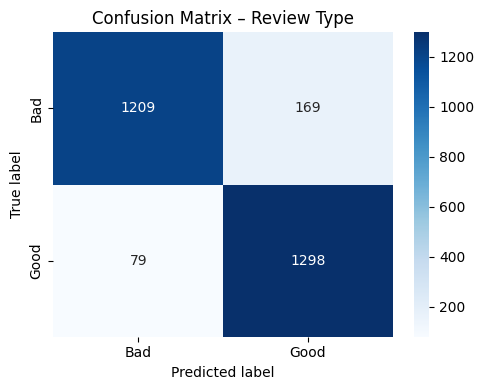


Regression (Review Score):
 MSE: 1.6362


In [ ]:
# Predict on test set
y_pred_type, y_pred_score = model.predict([X_text_test, X_nat_test, X_num_test])
y_pred_type_bin = (y_pred_type > 0.5).astype(int)

# Classification metrics
acc  = accuracy_score(y_type_test, y_pred_type_bin)
prec = precision_score(y_type_test, y_pred_type_bin)
rec  = recall_score(y_type_test, y_pred_type_bin)
f1   = f1_score(y_type_test, y_pred_type_bin)
cm   = confusion_matrix(y_type_test, y_pred_type_bin)

# Regression metric
mse  = mean_squared_error(y_score_test, y_pred_score)

# Print results
print("Classification (Review Type):")
print(f" Accuracy : {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall   : {rec:.4f}")
print(f" F1 Score : {f1:.4f}")

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Review Type")
plt.tight_layout()
plt.show()

print("\nRegression (Review Score):")
print(f" MSE: {mse:.4f}")


This multitask neural network successfully handles:

- **Review type classification**, where it achieves high validation accuracy (≈ 91%) and shows strong generalization ability.  
- **Review score regression**, which remains more challenging due to the inherent subjectivity and higher variability of continuous scores.

While dropout and early stopping helped prevent severe overfitting, some **moderate overfitting is still observed** in the regression head: training loss keeps decreasing, but validation loss plateaus after a few epochs. Despite this, the final MSE (≈ 1.66) remains acceptable.